# Simulated Based Inference of  BOLD by Generic Hopf model 

Here we first simulate a whole brain model of resting state, in which a generic Hopf bifurcation model is placed at each brain region and connected by SC matrix(N=84). Then the aim is to invert the model using simulated-based-inference (SBI), in which a deep learning architecture known as normalizing flow is trained on the data features extracted from a large number of simulations.

SBI provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

For inference, you need to provide two ingredients:

1) a prior distribution that allows to sample parameter sets.
2) a simulator that takes parameter sets and produces simulation outputs.


To install SBI, see https://github.com/mackelab/sbi.

Refs: 

[1] Deco, Gustavo, et al. "The dynamics of resting fluctuations in the brain: metastability and its dynamical cortical core." Scientific reports 7.1 (2017): 1-14. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5465179/)


[2] Gonçalves, Pedro J., et al. "Training deep neural density estimators to identify mechanistic models of neural dynamics." Elife 9 (2020): e56261. (https://elifesciences.org/articles/56261)

[3] Cranmer, Kyle, Johann Brehmer, and Gilles Louppe. "The frontier of simulation-based inference." Proceedings of the National Academy of Sciences 117.48 (2020): 30055-30062. (https://www.pnas.org/content/117/48/30055)


### Set up

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, infer, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.posteriors.base_posterior import NeuralPosterior

import sbi.utils as utils
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import ActiveSubspace, pairplot

In [4]:
from scipy import signal
from scipy import stats as spstats
from scipy.signal import hilbert

In [5]:
from FCD import extract_FCD

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [8]:
import warnings
warnings.simplefilter("ignore")

In [9]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [10]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.19.0
Running on torch: v1.8.0
Running on sbi: v0.15.1


In [11]:
sns.set(style="white")
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [12]:
cwd = os.getcwd()
cwd

'/data/SBI/GenericHopf_SBI'

In [13]:
import warnings
np.seterr(all = 'ignore')
warnings.filterwarnings("ignore")

In [14]:
Res_dir='Res_SBI_BNM_GenericHopf_InferG_randfreq_savesim10k'

# Load the Human Connectome

First we load the connectivity matrix (here, 84 X 84) and we normalize it between [0,1].

In [15]:
weights= np.loadtxt(cwd+ '/ExperimentalData/hcp_001/weights.txt')

In [16]:
weights.shape, weights.min(), weights.max()

((84, 84), 0.0, 8706.0)

In [17]:
nn=weights.shape[0]
print  ('The number of regions  is: ', nn)

The number of regions  is:  84


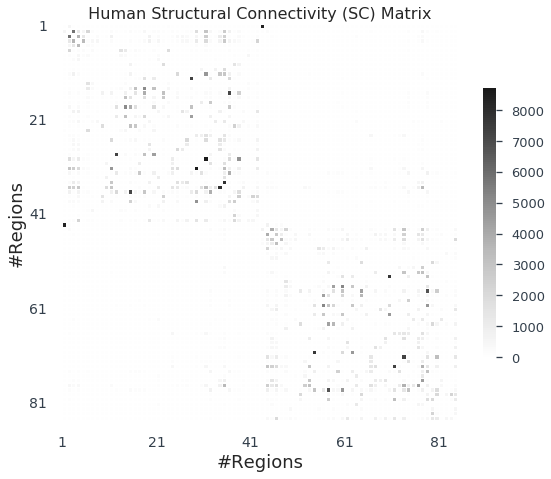

In [18]:
plt.figure(figsize=(8, 8))
mask = np.zeros_like(weights, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap='RdGy'
sns.heatmap(weights, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(' Human Structural Connectivity (SC) Matrix ',fontsize=16)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
plt.yticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
#plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix.eps"), doi=800)
plt.show()

In [19]:
con = weights/np.max(weights)

In [20]:
con.shape, con.min(), con.max()

((84, 84), 0.0, 1.0)

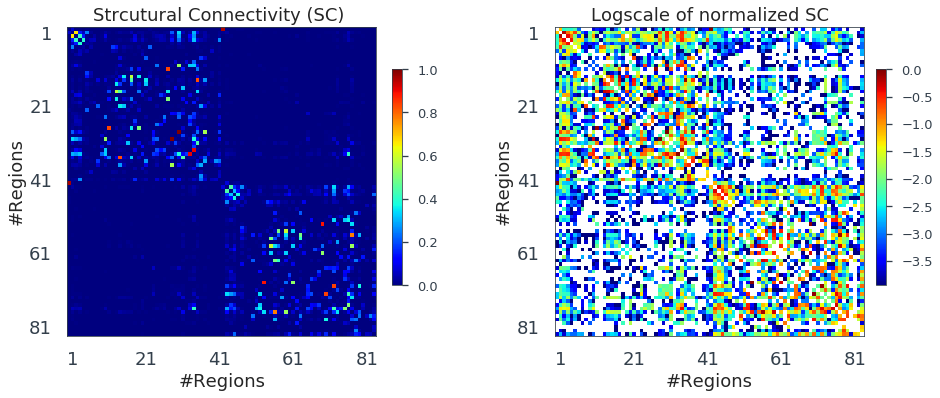

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
norm = colors.LogNorm(1e-7, con.max())
i=axs[0].imshow(con,cmap=cm.jet)
colorbar_ax = fig.add_axes([0.45, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[0].set_title('Strcutural Connectivity (SC) ', fontsize=18.0)
axs[0].set_ylabel('#Regions', fontsize=18.0)
axs[0].set_xlabel('#Regions', fontsize=18.0)
axs[0].tick_params(labelsize=18)
axs[0].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[0].yaxis.set_ticks(np.r_[1:nn+1][::20])

i=axs[1].imshow(np.log10(con),cmap=cm.jet)
colorbar_ax = fig.add_axes([.93, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[1].set_title('Logscale of normalized SC', fontsize=18.0)
axs[1].set_ylabel('#Regions', fontsize=18.0)
axs[1].set_xlabel('#Regions', fontsize=18.0)
axs[1].tick_params(labelsize=18)
axs[1].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[1].yaxis.set_ticks(np.r_[1:nn+1][::20])

fig.tight_layout(pad=2)

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_Normalized.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_Normalized.eps"), doi=800)
plt.show()

In [22]:
print("Values bigger than 0.5 =", con[con>0.5].shape)

Values bigger than 0.5 = (34,)


In [23]:
con_positive=con.flatten()[con.flatten() != 0]
con_positive.shape[0]

4598

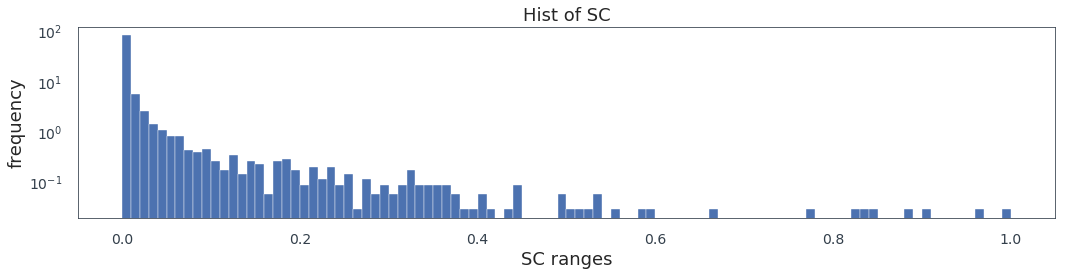

In [24]:
plt.figure(figsize=(15, 4))
plt.hist(con.flatten(), density=True, log=True, bins=100)
plt.title('Hist of SC', fontsize=18.0)
plt.ylabel('frequency', fontsize=18.0)
plt.xlabel('SC ranges', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Hist_SC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Hist_SC.eps"), doi=800)
plt.show()

In [25]:
IC=con[np.r_[0:nn]][:,:].sum(axis=1)

In [26]:
print("The strongest connections received to each node from other nodes: \n", np.argsort(-IC))

The strongest connections received to each node from other nodes: 
 [34 76 77 30 72 35 59 56  3  1 28 14 17  2 43 45 33 70 31 75 44 37 27 55
 10 73 13 63 69 57 53 83 61 79 19 41 11 36 15 21 78 24 52 47 66 42  5  0
 65 26 23 68 18 29 46 60  4 16 71 20 50 62 58 25  8 51 67 22 32 74  9 64
 40 80  6 82 48 12 54 38 39 81 49  7]


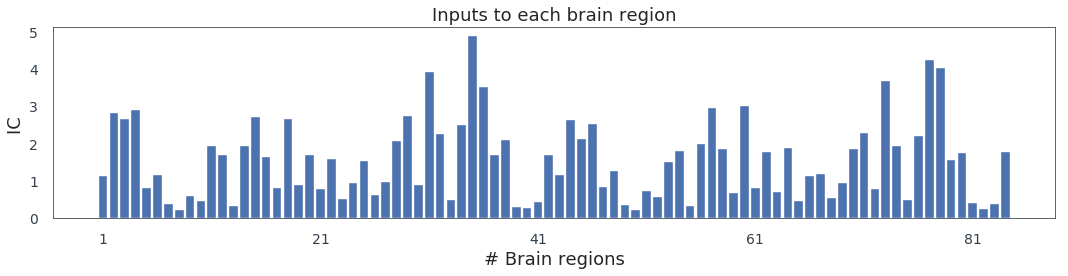

In [27]:
plt.figure(figsize=(15, 4))
plt.bar(np.r_[0:nn], IC)
plt.title('Inputs to each brain region', fontsize=18.0)
plt.ylabel('IC ', fontsize=18.0)
plt.xlabel('# Brain regions', fontsize=18.0)
plt.xticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"IC_SC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"IC_SC.eps"), doi=800)
plt.show()

In the following, we place a generic Hopf bifurcation at each brain region connected through SC matrix to each others (see ref [1]). We use JIT compilation from numba for fast simulation (note that the first compilation is slow, then it will be on-the-fly to produce efficient machine code!).

### constants

In [28]:
eta_c=0       
delta_eta=.5                  
prior_std =1.0
sd_thr=0.5

# whole-brain network simulation

$  \frac{d x_i}{dt}= (\eta_i-x_i^2-y_i^2)x_i -\omega_i y_i+ G \sum_{j=1}^{N} C_{j,i} ( x_j- x_i) +\sigma \xi_i(t)$

$ \frac{d y_i}{dt}= (\eta_i-x_i^2-y_i^2)y_i +\omega_i x_i + G \sum_{j=1}^{N} C_{j,i} ( y_j- y_i)+ \sigma \xi_i(t)$


where $\eta_i$ is the excitability (bifurcation paremeter), $C_{i,j}$ is the ij-element of SC matrix, $G$ is a global scaling parameter, $\xi_i$ is additive Gaussian noise with standard deviation $\sigma$.

This normal form has a supercritical bifurcation at a $\eta=0$, so that for a $\eta < 0$ the local dynamics has a stable fixed point  (which because of the additive noise corresponds to a low activity asynchronous state) and for a $\eta > 0$ there exists a stable limit cycle oscillation with frequency $f_j = \omega/2\pi$.

The function "GenericHopfmodel" takes the (arbitary) inputs as $\eta \in \mathbb{R}^N$ (ecitability), $\omega \in \mathbb{R}^N$ (intrinsic frequency), initial conditions for x and y (here same initial condition for all nodes), $\sigma$ (the noise level), $G$ (global scaling parameter), $\eta \in \mathbb{R}^{N \times N}$ (structral connectivity matrix), dt (time step for Euler integration here), ts (the time for simulation), and returns the $x \in \mathbb{R}^{N \times t}$ as the source brain activity). 

In this notebook, we generate the excitability parameters randomly from $\eta_i \sim \mathcal{N}(\mu,\,\sigma^{2})$, and the aim of inference is to estimate one parameter the global scaling parameter $G$. 

In [29]:
@jit(nopython=True) 
def GenericHopfmodel(eta, omega, init_conditions, sigma, G, SC, dt, ts):
    
    ## nt: number of data points per region and nn: number of brain regions
    nt=ts.shape[0]
    nn=SC.shape[0]
    
    ## global scaling parameter
    G=100*G

    # state variables
    x = np.zeros((nn, nt))  
    y = np.zeros((nn, nt))  

    ## initial conditions (similar value for all regions)
    x_init, y_init=init_conditions[0], init_conditions[1]
    x[:, 0] = x_init
    y[:, 0] = y_init
        
    ## integrate SDE using Euler scheme and for loop to accelerate by numba 
    for t in range(nt-1):    
        for i in range(nn):
                gx, gy= 0.0, 0.0
                for j in range(nn):
                        gx = gx + SC[j,i]*(x[j,t] - x[i,t])
                        gy = gy + SC[j,i]*(y[j,t] - y[i,t])
                dx =(x[i,t]*(eta[i]-(x[i,t]*x[i,t])-(y[i,t]*y[i,t]))) -(omega[i]*y[i,t]) +(G*gx)
                dy =(y[i,t]*(eta[i]-(x[i,t]*x[i,t])-(y[i,t]*y[i,t]))) +(omega[i]*x[i,t]) +(G*gy)
                x[i,t+1] = x[i,t] + dt*dx + np.sqrt(dt) * sigma * np.random.randn() 
                y[i,t+1] = y[i,t] + dt*dy + np.sqrt(dt) * sigma * np.random.randn() 
                
                
    return x.reshape(-1)  

Then the function "BalloonWindkessel" takes the simulated source activity and dt_bold as the inputs and returns the simulated BOLD signals.

In [30]:
@jit(nopython=True) 
def BalloonWindkessel(x_source, dt_bold):

    nt_=int(x_source.size);
    
    epsilon=0.5;
    itaus  = 1.25;
    itauf  = 2.5;
    itauo  = 1.02040816327;
    ialpha = 5.;
    Eo     = 0.4;
    V0     = 4.;
    k1     = 2.77264;
    k2     = 0.572;
    k3     = -0.43;

    x0 = np.array([0., 1., 1., 1.])
    x = np.zeros((nt_,4));
    b = np.zeros((nt_,1));

    x[0,:] = x0;
    b[0]  = V0*(k1- k1*x[0,3] + k2-k2*(x[0,3]/x[0,2]) + k3-k3*x[0,2]);

    for t in range(nt_-1): 
        x[t+1,0] = x[t,0] + dt_bold*( epsilon*x_source[t]-itaus*x[t,0]-itauf*(x[t,1]-1) );
        x[t+1,1] = x[t,1] + dt_bold*x[t,0];
        x[t+1,2] = x[t,2] + dt_bold*itauo*(x[t,1]-x[t,2]**ialpha);
        x[t+1,3] = x[t,3] + dt_bold*itauo*(x[t,1]*(1-(1-Eo)**(1/x[t,1]))/Eo - (x[t,2]**ialpha)*x[t,3]/x[t,2]);
        b[t+1]  = V0*(k1- k1*x[t+1,3] + k2-k2*(x[t+1,3]/x[t+1,2]) + k3-k3*x[t+1,2] );

    return b

lastly, the function "GenericHopfBOLD" wrap the both functions "GenericHopfmodel" and "BalloonWindkessel". Here ds is the downsampling from source level to BOLD signal. The dimention of outout BOLD signals is $nn \times nt_{bold}$, where $nn$ is number of brain regions and $nt_{bold}=int(nt/ds)$ is number of data points at measurement (BOLD) level for each region.

In [31]:
@jit(nopython=True) 
def GenericHopfBOLD(eta, omega, init_conditions, sigma, G, SC, dt, ts, dt_bold, ds):
   
    nt=ts.shape[0]
    nn=SC.shape[0]
    
    Sim=GenericHopfmodel(eta, omega, init_conditions, sigma, G, SC, dt, ts)
    neural_act=Sim.reshape(nn, int(Sim.shape[0]/nn))

    fmri = np.zeros((nt,nn,1));
    B =np.zeros((int(nt/ds),1));
    
    nt_bold=fmri[::ds,:].shape[0]
    BOLD = np.zeros((nn, nt_bold))  
    
    for node in range(nn):
        B = BalloonWindkessel(neural_act.T[:,node], dt_bold);
        fmri[:,node] = B;
        BOLD[node,:]=fmri[::ds,node,0].T
        
    return BOLD.reshape(-1)  

Here, the function "calculate_summary_statistics" provides the data features from simulated BOLD signals. 
This function takes the simulated BOLD signals (with dimention $nn \times nt_{bold}$), $nn$ as the number of brain regions and the features as the time invariant statistical moments including mean, median, std, skew, kurtosis, independently for each node. It also provides higher_moments (by order of ten), spectral_power, envelope (calculated from hilbert function), FC_corr (eigen_vals and PCA of functional connectivity matrix) and FCD_corr (eigen_vals_FC and PCA of functional connectivity dynamic matrix using sliding window). The output (sum_stats_vec) is vectorized for SBI. Note that for SBI, the input parameter set should have either shape (1,N) or (N), and the output must have shape (1,M) or (M).

This function is arbitrary and task dependent. The higher dimention will require the more computational time for the NN training, but it should be enough informative to provide the informative posteriors (the non-relevant features results just in waste of time and posterior will be closer to prior). This why we use only eigen_vals and PCA of FC and FCD matrices.  

In [32]:
from GenericHopf_features import calculate_summary_statistics

Finally, we wrap all the functions for foward simulation (e.g., "GenericHopfBOLD") and constants into the function "GenericHopf_simulator_wrapper", which it should takes only parameters as the input. The output can be stat summary of features for SBI. However, due to the computational cost of a large number of simulations, we first simulate and save the raw time series, then we load, calculate the features and run the SBI. 

In [33]:
def GenericHopf_simulator_wrapper(params):

    params = np.asarray(params)
    
    ## fixed values: simulation time lenght (T), the time step (dt), the rray of time points (ts),  
    ##            noise level (sigma), time step for BalloonWindkessel, downsampling (ds), 
    T = 120.0
    dt=0.001
    ts = np.arange(0, T + dt, dt)
    sigma=1e-1
    dt_bold=0.001
    ds=180

    ## Constant values: the intrinsic frequency generated randomly between [0.02-0.04] HZ 
    nn=int(SC.shape[0])
    freq = np.random.uniform(0.02, 0.04,nn)
    omega=2*np.pi*freq


    ## initial conditions
    x_init=0
    y_init=0
    init_conditions = np.array([x_init, y_init])

    ##param : global coupling parameter (G)
    params_G=params[0]
    
    
    BOLD_simulated =GenericHopfBOLD(eta_true, omega, init_conditions, sigma, params_G, SC, dt, ts, dt_bold, ds)

    #summstats = torch.as_tensor(calculate_summary_statistics(BOLD_, nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr']))

    return BOLD_simulated 

### some simulations for  sanity check


Here we just perform a sanity check for the simulation providing us the FCD.
It is always useful to run some simulations befor the inference (a prior predictive check) on the plausible range of parameters such as dt and G (for high values of dt and G, the euler integraion can diverge.) Though SBI ignores the NAN and INF, but it will be waste of comupational time.

In [34]:
T = 120.0
dt=0.001
ts = np.arange(0, T + dt, dt)
sigma=1e-1

In [35]:
dt_bold=0.001
ds=180

In [36]:
nt=ts.shape[0]
nt

120001

In [37]:
SC=con
nn=SC.shape[0]
nn

84

In [38]:
freq_true = np.random.uniform(0.02, 0.04,nn)
omega_true=2*np.pi*freq_true
omega_true.shape

(84,)

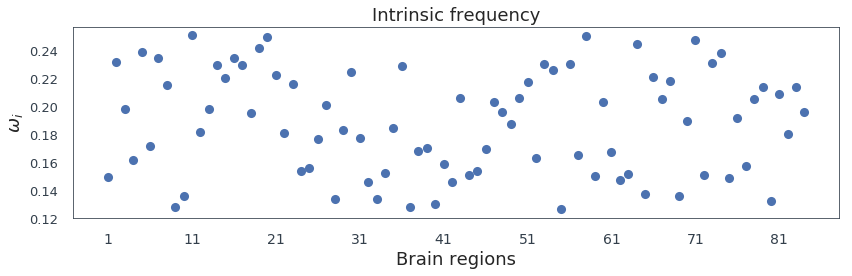

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(omega_true, 'bo')
plt.title('Intrinsic frequency',fontsize=18)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\omega_i$',fontsize=18)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.eps"), doi=800)
plt.show()

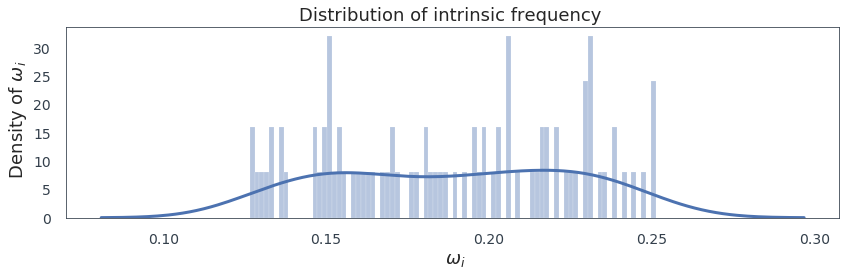

In [40]:
plt.figure(figsize=(12, 4))
prior_plot=sns.distplot(omega_true, bins=84,hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.title('Distribution of intrinsic frequency ',fontsize=18)
plt.ylabel(' Density of $\omega_i$',fontsize=18)
plt.xlabel(' $\omega_i$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"HistOmega_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"HistOmega_true.eps"), doi=800)
plt.show()

In [41]:
eta_mu_true=-1.
eta_std_true=1.
eta_heter_rnd=np.random.randn(nn) 

In [42]:
eta_true=eta_mu_true+eta_std_true * eta_heter_rnd
eta_true.shape 

(84,)

In [43]:
## for the case of bi-modality
# eta_ws_true = pm.floatX([0.8, 0.2])
# eta_mu_true = pm.floatX([-3.0, -1.0])
# eta_std_true = pm.floatX([0.1, 0.1])
#components=np.random.choice(eta_mu_true.size, size=nn, p=eta_ws_true)
#eta_true=np.random.normal(mu[components], std[components], size=nn)

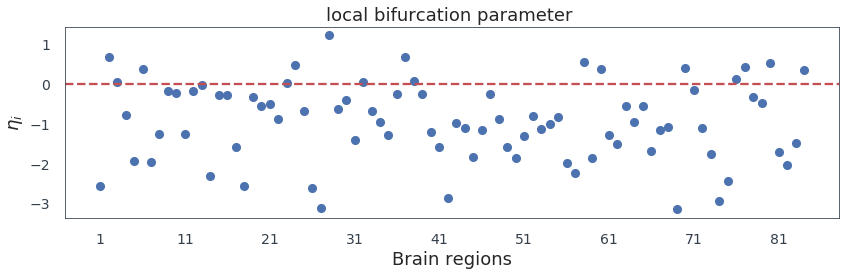

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(eta_true, 'bo')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('local bifurcation parameter ',fontsize=18)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\eta_i$',fontsize=18)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.eps"), doi=800)
plt.show()

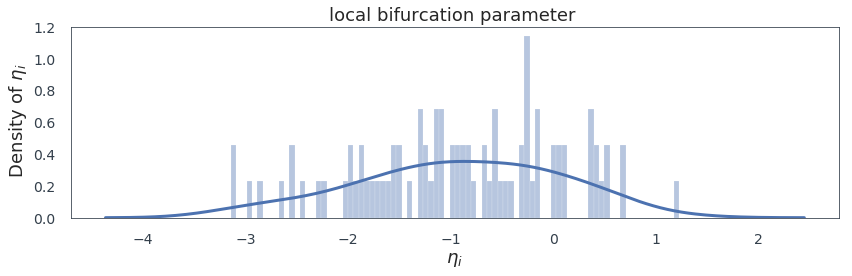

In [45]:
plt.figure(figsize=(12, 4))
#plt.hist(eta_true, bins=84);
prior_plot=sns.distplot(eta_true, bins=84, hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
#plt.plot(x, y)
plt.title('local bifurcation parameter ',fontsize=18)
plt.ylabel(' Density of $\eta_i$',fontsize=18)
plt.xlabel('$\eta_i$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"HistEta_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"HistEta_true.eps"), doi=800)
plt.show()

In [46]:
G_true=0.25

In [47]:
# stacking all the params
params_true = np.hstack([G_true])
params_true.shape

(1,)

In [48]:
params_true

array([0.25])

In [49]:
np.save(os.path.join(Res_dir, 'eta_true.npy') , eta_true)
np.save(os.path.join(Res_dir, 'omega_true.npy') , omega_true)
np.save(os.path.join(Res_dir, 'params_true.npy') , params_true)

In [50]:
x_init=0
y_init=0
init_conditions = np.array([x_init, y_init])

In [51]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC, dt, ts, dt_bold, ds)

print(" one simulation (sec) takes:" , (time.time() - start_time))

 one simulation (sec) takes: 7.050947904586792


In [52]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC, dt, ts, dt_bold, ds)

print(" one JIT simulation  (sec) takes:" , (time.time() - start_time))

 one JIT simulation  (sec) takes: 4.603369951248169


In [53]:
BOLD_.shape

(56028,)

In [54]:
BOLD_sanity=BOLD_.reshape(nn, int(BOLD_.shape[0]/nn))

BOLD_sanity.shape

(84, 667)

In [55]:
np.save(os.path.join(Res_dir, 'Sim_BOLD_sanity_GenericHopf_Hierarchy_lowcoupling.npy') , BOLD_sanity)

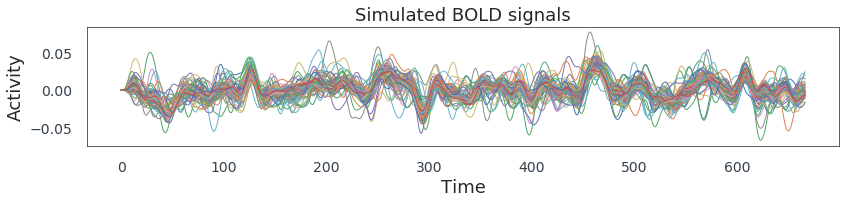

In [56]:
plt.figure(figsize=(12,3))
plt.plot(BOLD_sanity.T, lw=1)
plt.title("Simulated BOLD signals",fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Activity',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.eps"), doi=800)
plt.show()

In [57]:
fs = 10e3

f, Pxx_den =  signal.periodogram(BOLD_sanity, fs)
analytic_signal = hilbert(BOLD_sanity)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

In [58]:
Pxx_den.shape, f.shape

((84, 334), (334,))

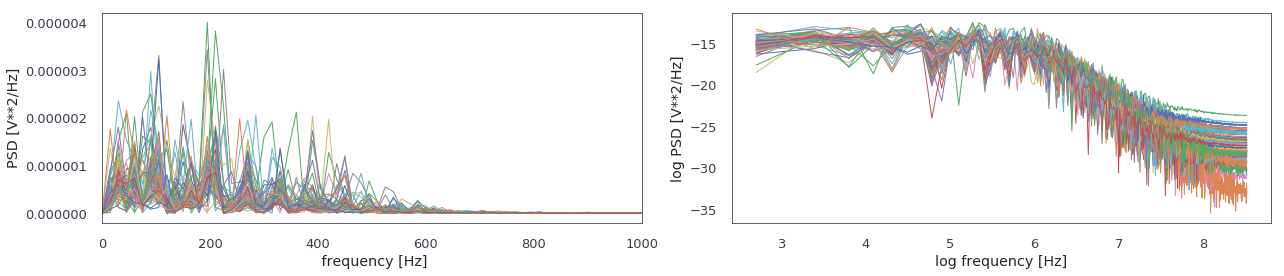

In [59]:
plt.figure(figsize=(18, 4))
plt.subplot(121)
for i in np.r_[0:nn]:
    plt.plot((f), (Pxx_den[i,:]), lw=1)
plt.xlabel(' frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0,1000])
plt.subplot(122)
for i in np.r_[0:nn]:
    plt.plot(np.log(f), np.log(Pxx_den[i,:]), lw=1)
plt.xlabel('log frequency [Hz]')
plt.ylabel('log PSD [V**2/Hz]')
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SpecytalPower.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SpecytalPower.eps"), doi=800)
plt.show()

In [60]:
amplitude_envelope.shape, instantaneous_phase.shape

((84, 667), (84, 667))

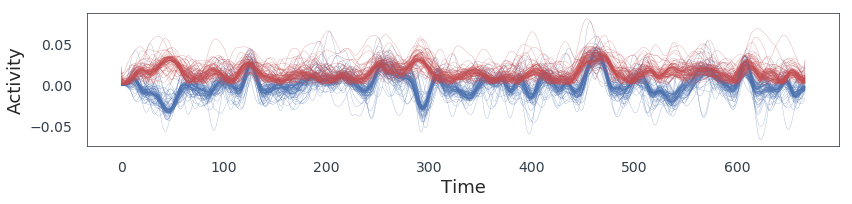

In [61]:
plt.figure(figsize=(12,3))
plt.plot(BOLD_sanity.T, 'b', lw=.2)
plt.plot(amplitude_envelope.T, 'r', lw=.2)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Activity',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_envelope.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_envelope.eps"), doi=800)
plt.show()

In [62]:
FCcorr=np.corrcoef(BOLD_sanity)
FCcorr.shape

(84, 84)

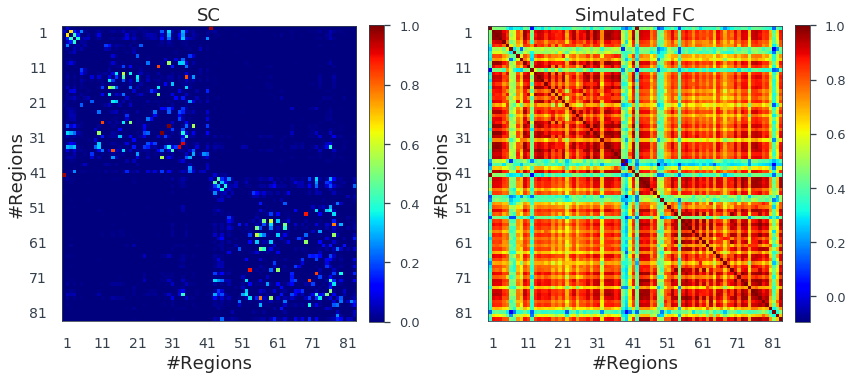

In [63]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SC', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Simulated FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC.eps"), doi=800)
plt.show()

In [64]:
wwidth=30
maxNwindows=200
olap=0.94

In [65]:
FCDcorr,Pcorr,shift=extract_FCD(BOLD_sanity,wwidth,maxNwindows,olap,mode='corr')
FCDcorr.shape

(207, 207)

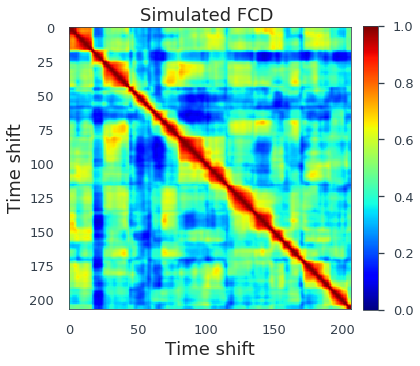

In [66]:
plt.figure(figsize=(6, 6))
plt.imshow(FCDcorr, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Simulated FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.eps"), doi=800)
plt.show()

In [67]:
_=calculate_summary_statistics(BOLD_, nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr'])
print('feature shape:', _.shape)

feature shape: (2172,)


### 2. Prior over model parameters

Here we provide a plausible ranges for the parameters we want to infer, by placing a uniform prior on them.

In [68]:
prior_min_G=0.*np.ones(1)

prior_max_G=0.6*np.ones(1)

In [69]:
prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [70]:
prior_min.shape, prior_max.shape

((1,), (1,))

In [71]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [72]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 1


### Save simulations

Since running a large number of simulations is computationally expensive, we save the simulations generated from a random sampling of parameters. This allows us to perform ad-hoc inference on the simulations to investigate the role of different features without re-simulation.

In [73]:
num_sim=10000

In [74]:
mysavepath = os.path.join(Res_dir, 'output_simulations/simulated_theta_x_GenericHopf.npz')
mysavepath

'Res_SBI_BNM_GenericHopf_InferG_randfreq_savesim10k/output_simulations/simulated_theta_x_GenericHopf.npz'

In [75]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(
                                simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    #print(theta,flush=True)
    print( 'theta shape:',theta.shape,flush=True)
    #print(x,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)


Since we place our simulator in another function, we need to run it for a single simulation, for later beneficiation of JIT. In the saving, the parameters are referred to as the vector theta, and the BOLD signals as $x$ reshaped to vector (dimention will be $nn \times nt$). Finnaly, their dimention are: $theta \in [n_{sim} , n_{params}]$, and $ x \in [n_{sim},  nn \times nt] $. 


In [76]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 1])
data shape: torch.Size([1, 56028])
------------------------------------------------------------
--- one simulation took: 11.093343496322632 seconds ---


In [77]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


theta shape: torch.Size([10000, 1])
data shape: torch.Size([10000, 56028])
------------------------------------------------------------
---all simulations took:  40140.76670885086 seconds ---


### Load simulations and calculate features

In [78]:
loaded_simulations=np.load(mysavepath)

In [79]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [80]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (10000, 1)
data shape: (10000, 56028)


In [81]:
_=_=calculate_summary_statistics(x_sim[0,:], nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr'])
_.shape

num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 2172


Now we are ready to provide the inputs as random sampled theta from prior (the set of parameters we aim to infer)and the features of observation x for inference (in torch tensor format). Given parameter $\theta$ and observation $x$, we can then sample from the posterior $p(\theta|x)$, evaluate its log-probability, or plot it. 

The dimention of theta is [number_simulations $\times$ number_parameters] and x is [number_simulations $\times$ number_features].

At the moments, sbi works only with float32.

In [82]:
num_features=2172

In [83]:
theta_features=np.zeros((num_sim,num_params))
x_features=np.zeros((num_sim,num_features))

In [84]:
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

theta shape: (10000, 1)
data frature shape: (10000, 2172)


In [85]:
theta_features=theta_sim

In [86]:
start_time = time.time()

for i in range(num_sim):
    x_features[i,:]=calculate_summary_statistics(x_sim[i,:], nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr'])
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- Calculating features took: 2877.094391822815 seconds ---


In [87]:
np.isnan(np.sum(x_features))

False

In [88]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [89]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 1])
data feature shape: torch.Size([10000, 2172])


### 3. Inference

Finally we use Sequential Neural Posterior Estimation (SNPE) to sample from the posterior $p(\theta|x)$. The inputs are prior, parameter theta and (features of) observation x, and it return the posterior $p(\theta|x)$.

In [90]:
def myinference_SNPE(prior, theta, x):
    
    inference = SNPE(prior)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

    return posterior

In [91]:
start_time = time.time()

posterior = myinference_SNPE(prior, theta, x)

print ("-"*60)
print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

Neural network successfully converged after 55 epochs.
------------------------------------------------------------
--- Training neural network took: 145.62215924263 seconds ---


In [92]:
## Without the saving and loading simulations, we can run sbi using the default function "infer", as follows:
##posterior = infer(GenericHopf_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

### Observed data

After the training NN, the posterior is amortized (i.e., no need to again train NN) and by providing the features of observation (empirical or simulated with same dimension as we used for training), we are able to efficiently obtain the posterior of parameters.

In the following we use the ground-truth for simulation to validate the inference.

In [93]:
start_time = time.time()

BOLD_obs =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC, dt, ts, dt_bold, ds)


print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.8914809226989746


In [94]:
obs_bold_features=calculate_summary_statistics(BOLD_obs, nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr'])

In [95]:
BOLD_obs.shape, obs_bold_features.shape

((56028,), (2172,))

In [96]:
x_obs=BOLD_obs.reshape(nn, int(BOLD_obs.shape[0]/nn))
x_obs.shape

(84, 667)

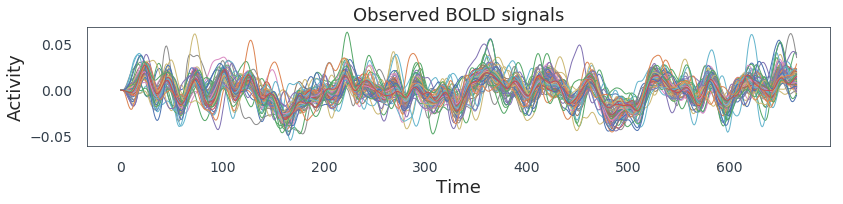

In [97]:
plt.figure(figsize=(12,3))
plt.plot(x_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Activity',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs.eps"), doi=800)
plt.show()

In [98]:
FCcorr_obs=np.corrcoef(x_obs)
FCcorr_obs.shape

(84, 84)

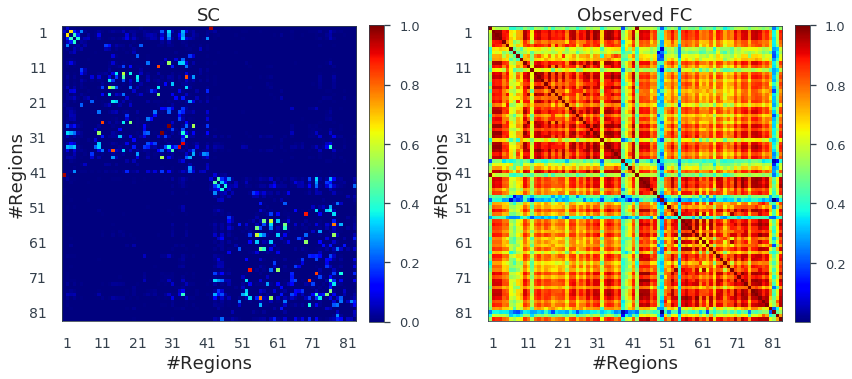

In [99]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SC', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr_obs,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_obs.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_obs.eps"), doi=800)
plt.show()

In [100]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(x_obs,wwidth,maxNwindows,olap,mode='corr')

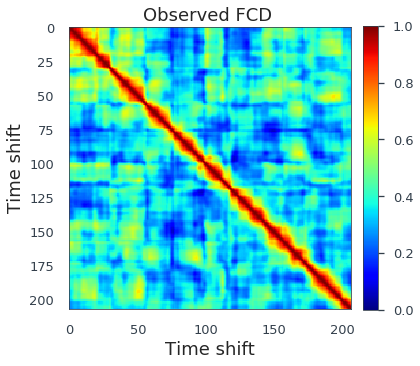

In [101]:
plt.figure(figsize=(6, 6))
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FCD_obs.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FCD_obs.eps"), doi=800)
plt.show()

### Posterior

In [102]:
labels_params = [r'$G$']

In [103]:
num_samples=1000

In [104]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features, sample_with_mcmc=True,).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))



Generating samples: 100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s]

 Sampling posterior (sec) took: 142.60529446601868


In [105]:
np.save(os.path.join(Res_dir, 'posterior_samples_GenericHopf_Hierarchy.npy') , posterior_samples)

In [106]:
posterior_samples.shape, params_true.shape

((1000, 1), (1,))

In [107]:
G_posterior=posterior_samples[:,0]

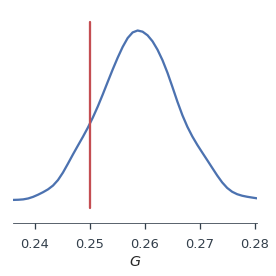

In [108]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(4,4),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=params_true,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde.eps"), doi=800) 
plt.show()

In [109]:
G_posterior.mean()

0.25889733

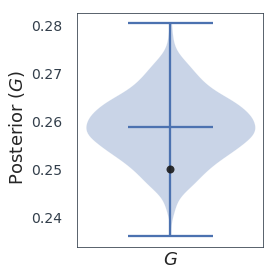

In [110]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.eps"), doi=800)
plt.show()

In [111]:
#x_fit =GenericHopfBOLD(np.percentile(posterior_sample, [50], axis=0).reshape(-1), omega, init_conditions, sigma, SC, dt, ts, dt_bold, ds, seed=0)
BOLD_fit =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC, dt, ts, dt_bold, ds)

In [112]:
x_fit=BOLD_fit.reshape(nn, int(BOLD_fit.shape[0]/nn))

In [113]:
x_obs.shape, x_fit.shape, 

((84, 667), (84, 667))

In [114]:
np.save(os.path.join(Res_dir, 'x_obs_GenericHopf_Hierarchy.npy') , x_obs)
np.save(os.path.join(Res_dir, 'x_fit_GenericHopf_Hierarchy.npy') , x_fit)

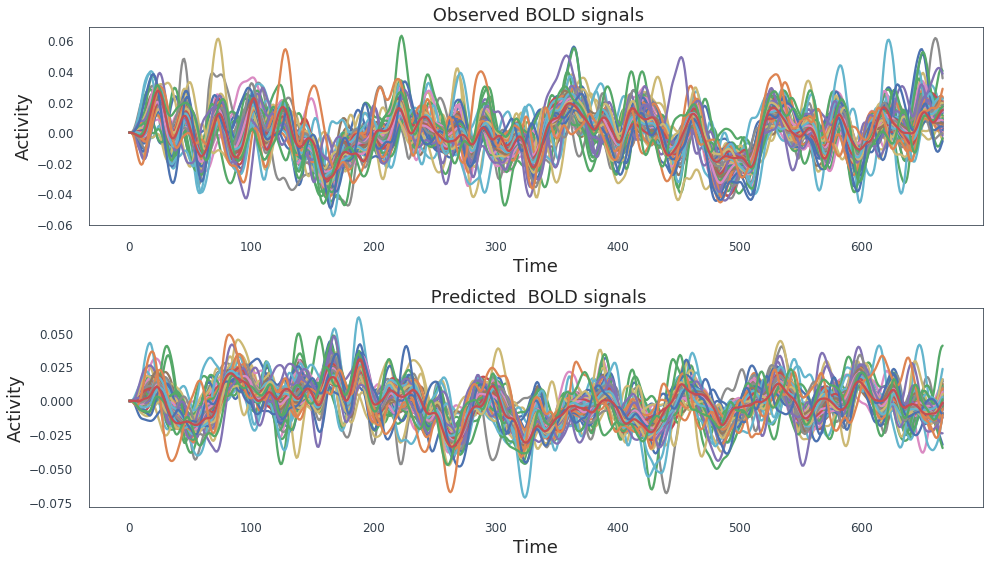

In [115]:
plt.figure(figsize=(14, 8))
plt.subplot(211);
plt.plot(x_obs.T)
plt.title(" Observed BOLD signals", fontsize=18) 
plt.xlabel("Time", fontsize=18);
plt.ylabel("Activity", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(212)
plt.plot(x_fit.T)
plt.title(" Predicted  BOLD signals", fontsize=18) 
plt.xlabel("Time", fontsize=18);
plt.ylabel("Activity", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedSeriesobservation_obs.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedSeriesobservation_obs.eps"), doi=800)
plt.show()

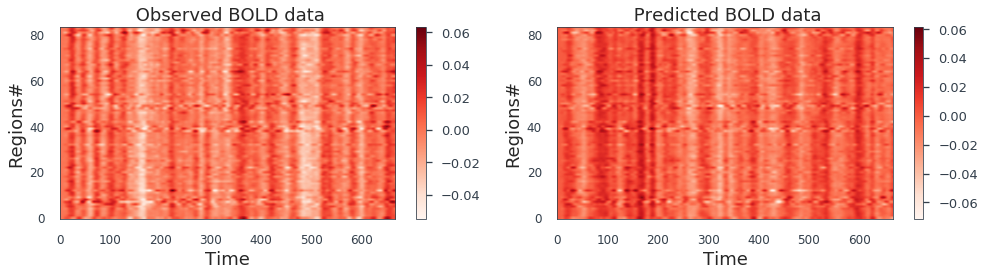

In [116]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(x_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Observed BOLD data", fontsize=18) 
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(122)
plt.imshow(x_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted BOLD data", fontsize=18) 
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_ImshowFittedobservation.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_ImshowFittedobservation.eps"), doi=800)
plt.show()

In [117]:
FCcorr_obs=np.corrcoef(x_obs)
FCcorr_fit=np.corrcoef(x_fit)

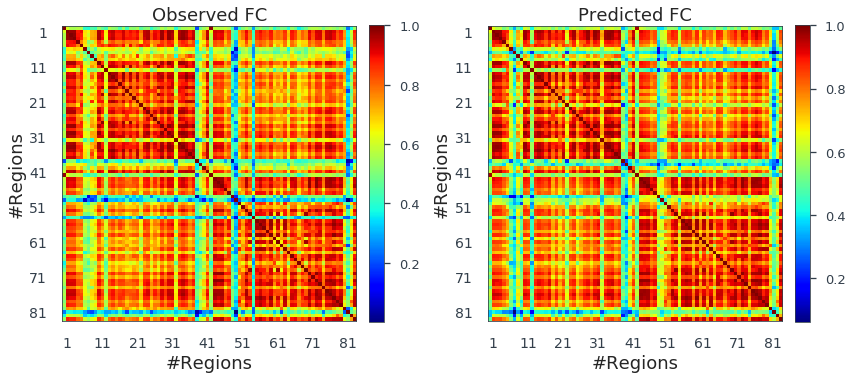

In [118]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)

plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC.eps"), doi=800)
plt.show()

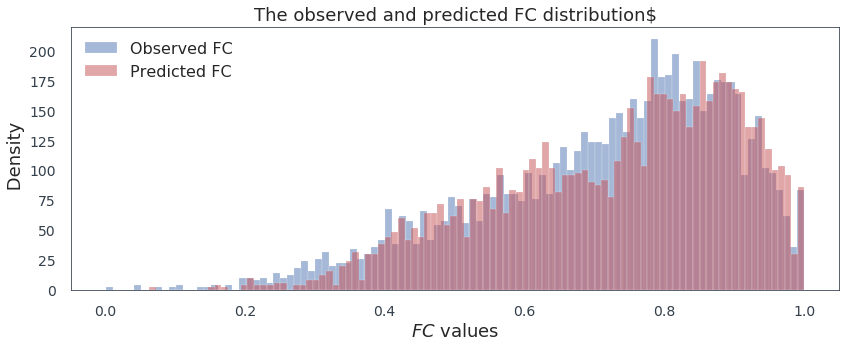

In [119]:
plt.figure(figsize=(12, 5))
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC distribution$', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFC.eps"), doi=800)
plt.show()

In [120]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(60.09768961659581, 61.35287629765573)

In [121]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(x_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(x_fit,wwidth,maxNwindows,olap,mode='corr')

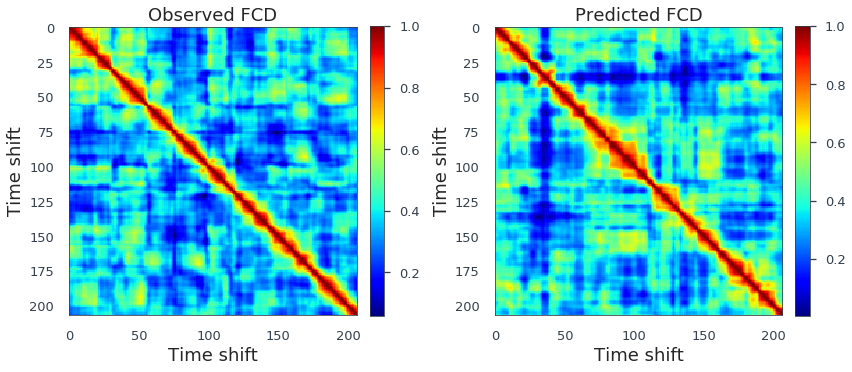

In [122]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD.eps"), doi=800)
plt.show()

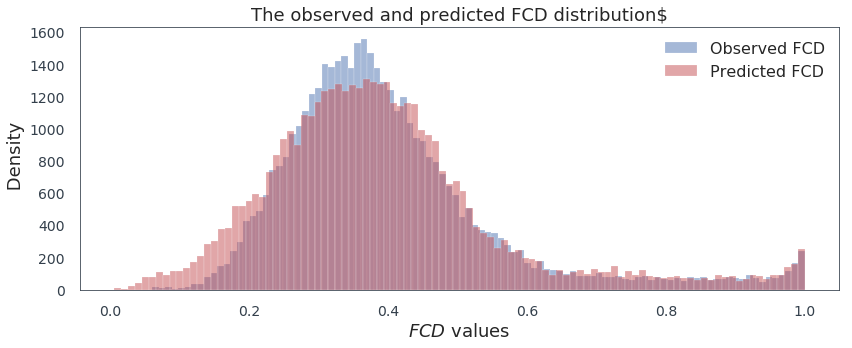

In [123]:
plt.figure(figsize=(12, 5))
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD distribution$', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFCD.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFCD.eps"), doi=800)
plt.show()

In [124]:
#from Similaritymetrics import kl_divergence, compute_kl_divergence, js_divergence, compute_js_divergence

In [125]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from sklearn.metrics import mutual_info_score

In [126]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [127]:
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [128]:
kl_divergence(FCDcorr_obs, FCDcorr_fit)

1921.4037633638377

In [129]:
kl_divergence(FCDcorr_fit, FCDcorr_obs)

977.0572814573147

In [130]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

348.92510691819064

In [131]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.013448472346077045

In [132]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.032963263794217594

In [133]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

Ks_2sampResult(statistic=0.06291862120469557, pvalue=3.2408946680250758e-74)

# Another data set

### Observed data set 2

In [134]:
G_true=0.1

In [135]:
# stacking all the params
params_true = np.hstack([G_true])
params_true.shape

(1,)

In [136]:
params_true

array([0.1])

In [137]:
np.save(os.path.join(Res_dir, 'params_true2.npy') , params_true)

In [138]:
start_time = time.time()

BOLD_obs =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC, dt, ts, dt_bold, ds)


print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 4.079667091369629


In [139]:
obs_bold_features=calculate_summary_statistics(BOLD_obs, nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr'])

In [140]:
BOLD_obs.shape, obs_bold_features.shape

((56028,), (2172,))

In [141]:
x_obs=BOLD_obs.reshape(nn, int(BOLD_obs.shape[0]/nn))
x_obs.shape

(84, 667)

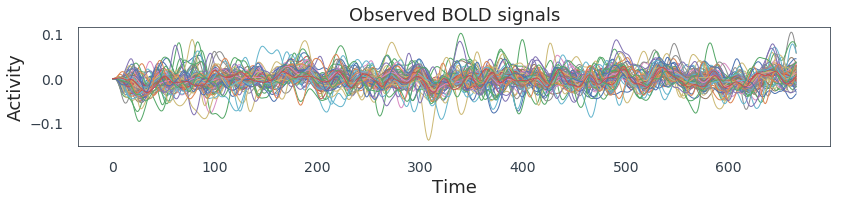

In [142]:
plt.figure(figsize=(12,3))
plt.plot(x_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Activity',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.eps"), doi=800)
plt.show()

In [143]:
FCcorr_obs=np.corrcoef(x_obs)
FCcorr_obs.shape

(84, 84)

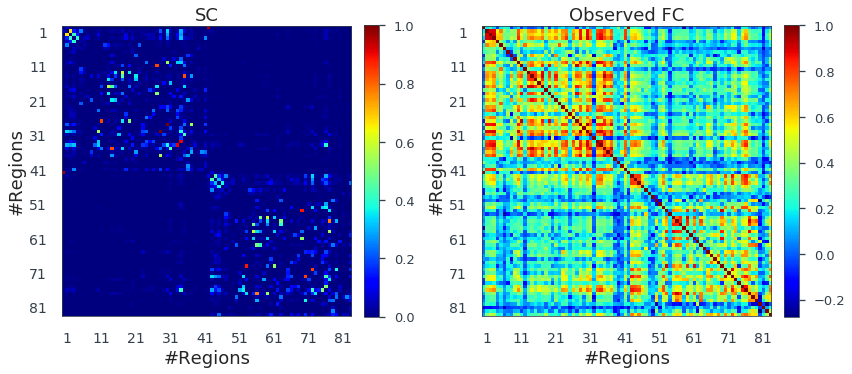

In [144]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SC', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr_obs,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_obs2.eps"), doi=800)
plt.show()

In [145]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(x_obs,wwidth,maxNwindows,olap,mode='corr')

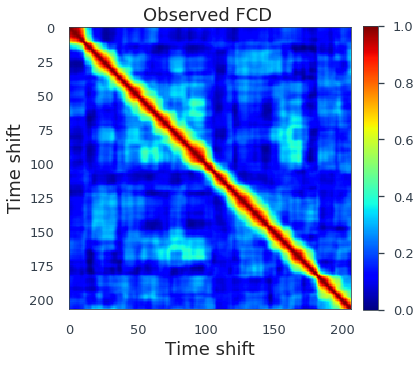

In [146]:
plt.figure(figsize=(6, 6))
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FCD_obs2.eps"), doi=800)
plt.show()

### Posterior data set 2

In [147]:
labels_params = [r'$G$']

In [148]:
num_samples=1000

In [149]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features, sample_with_mcmc=True,).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))


Generating samples: 100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s]

 Sampling posterior (sec) took: 147.97664523124695


In [150]:
np.save(os.path.join(Res_dir, 'posterior_samples_GenericHopf_Hierarchy2.npy') , posterior_samples)

In [151]:
posterior_samples.shape, params_true.shape

((1000, 1), (1,))

In [152]:
G_posterior=posterior_samples[:,0]

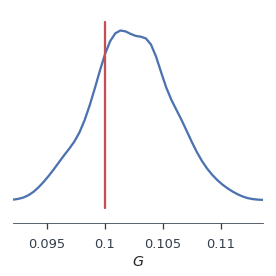

In [153]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(4,4),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=params_true,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs2.eps"), doi=800) 
plt.show()

In [154]:
G_posterior.mean()

0.10233776

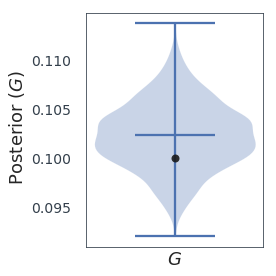

In [155]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.eps"), doi=800)
plt.show()

In [156]:
#x_fit =GenericHopfBOLD(np.percentile(posterior_sample, [50], axis=0).reshape(-1), omega, init_conditions, sigma, SC, dt, ts, dt_bold, ds, seed=0)
BOLD_fit =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC, dt, ts, dt_bold, ds)

In [157]:
x_fit=BOLD_fit.reshape(nn, int(BOLD_fit.shape[0]/nn))

In [158]:
x_obs.shape, x_fit.shape, 

((84, 667), (84, 667))

In [159]:
np.save(os.path.join(Res_dir, 'x_obs_GenericHopf_Hierarchy2.npy') , x_obs)
np.save(os.path.join(Res_dir, 'x_fit_GenericHopf_Hierarchy2.npy') , x_fit)

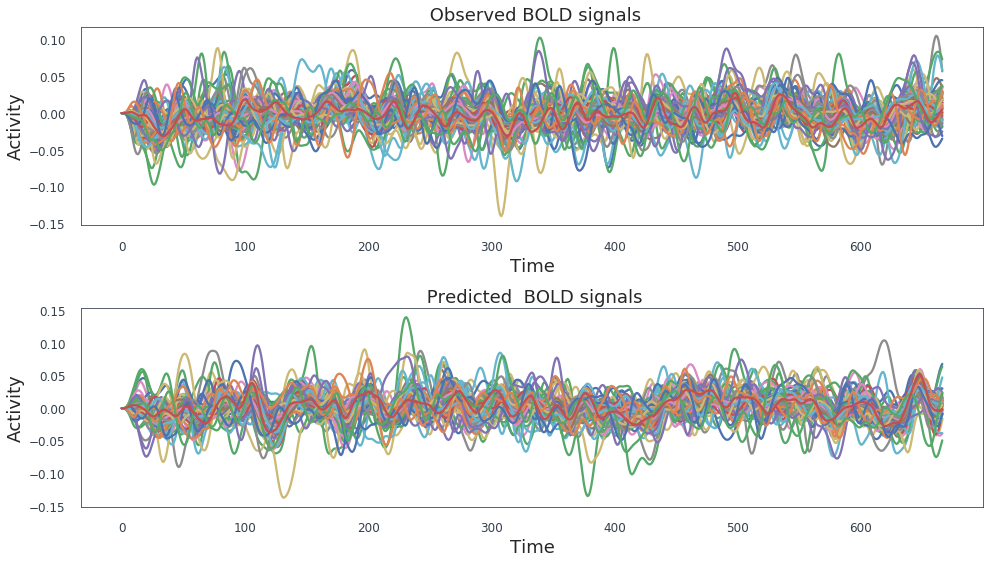

In [160]:
plt.figure(figsize=(14, 8))
plt.subplot(211);
plt.plot(x_obs.T)
plt.title(" Observed BOLD signals", fontsize=18) 
plt.xlabel("Time", fontsize=18);
plt.ylabel("Activity", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(212)
plt.plot(x_fit.T)
plt.title(" Predicted  BOLD signals", fontsize=18) 
plt.xlabel("Time", fontsize=18);
plt.ylabel("Activity", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedSeriesobservation_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedSeriesobservation_obs2.eps"), doi=800)
plt.show()

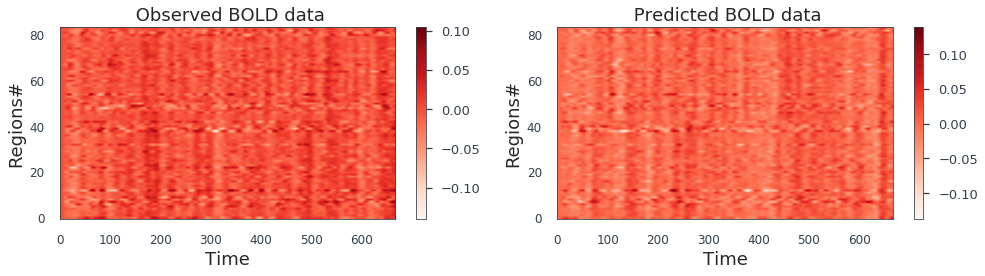

In [161]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(x_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Observed BOLD data", fontsize=18) 
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(122)
plt.imshow(x_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted BOLD data", fontsize=18) 
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_ImshowFittedobservation2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_ImshowFittedobservation2.eps"), doi=800)
plt.show()

In [162]:
FCcorr_obs=np.corrcoef(x_obs)
FCcorr_fit=np.corrcoef(x_fit)

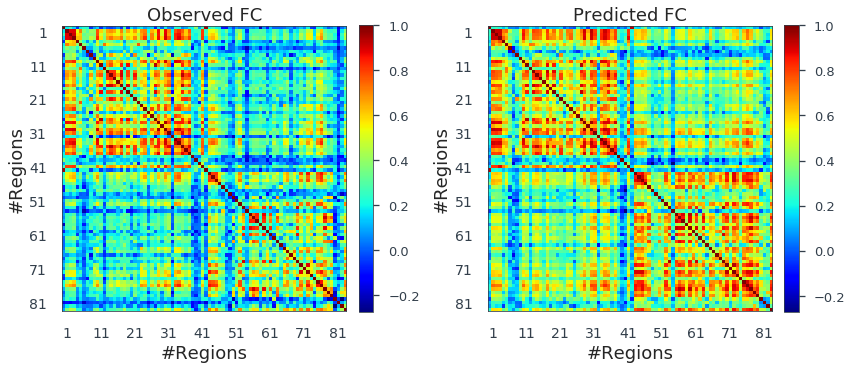

In [163]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)

plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC2.eps"), doi=800)
plt.show()

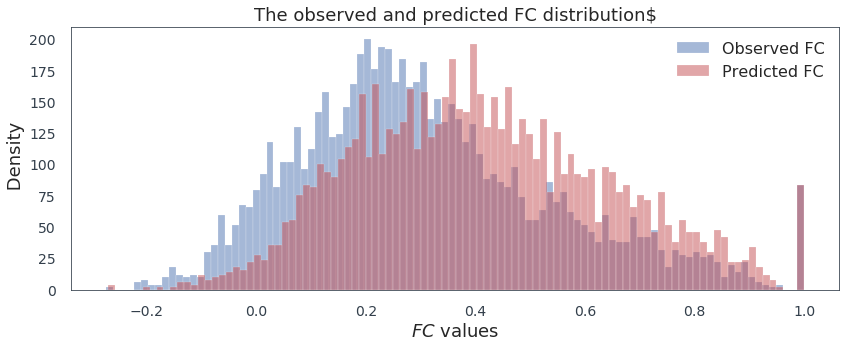

In [164]:
plt.figure(figsize=(12, 5))
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC distribution$', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFC2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFC2.eps"), doi=800)
plt.show()

In [165]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(25.985006275608526, 34.43593292630535)

In [166]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(x_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(x_fit,wwidth,maxNwindows,olap,mode='corr')

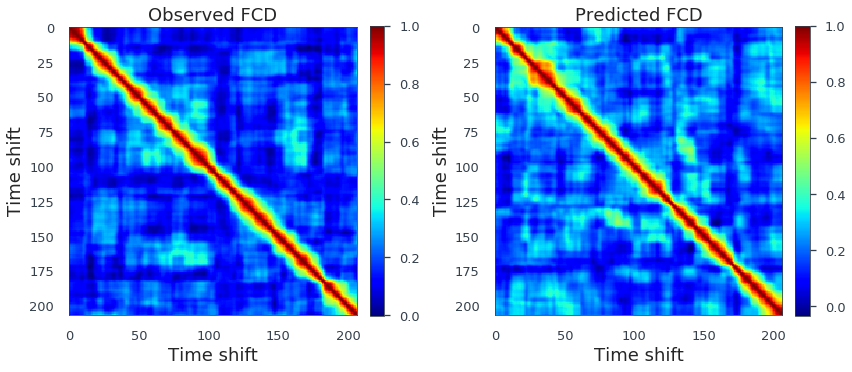

In [167]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD2.eps"), doi=800)
plt.show()

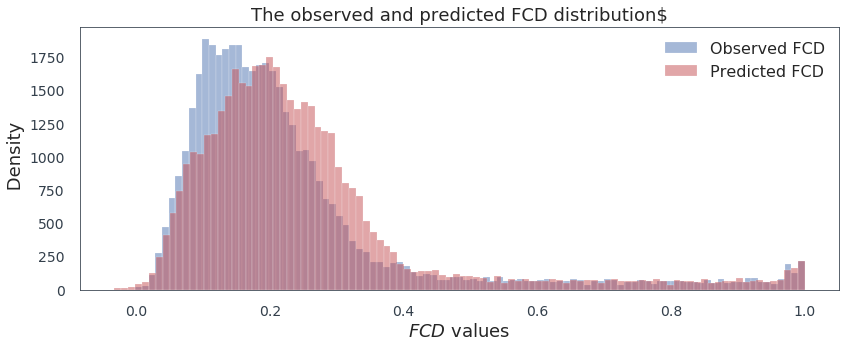

In [168]:
plt.figure(figsize=(12, 5))
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD distribution$', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFCD2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFCD2.eps"), doi=800)
plt.show()

In [169]:
#from Similaritymetrics import kl_divergence, compute_kl_divergence, js_divergence, compute_js_divergence

In [170]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from sklearn.metrics import mutual_info_score

In [171]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [172]:
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [173]:
kl_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [174]:
kl_divergence(FCDcorr_fit, FCDcorr_obs)

nan

In [175]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [176]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.022114758186576537

In [177]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.06203364182253774

In [178]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

Ks_2sampResult(statistic=0.11575532684543394, pvalue=3.473988583443346e-250)

# Another Data Set

### Observed data set 3

In [179]:
G_true=0.35

In [180]:
# stacking all the params
params_true = np.hstack([G_true])
params_true.shape

(1,)

In [181]:
params_true

array([0.35])

In [182]:
np.save(os.path.join(Res_dir, 'params_true3.npy') , params_true)

In [183]:
start_time = time.time()

BOLD_obs =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC, dt, ts, dt_bold, ds)


print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.8902149200439453


In [184]:
obs_bold_features=calculate_summary_statistics(BOLD_obs, nn, features=['higher_moments', 'spectral_power', 'envelope', 'FC_corr', 'FCD_corr'])

In [185]:
BOLD_obs.shape, obs_bold_features.shape

((56028,), (2172,))

In [186]:
x_obs=BOLD_obs.reshape(nn, int(BOLD_obs.shape[0]/nn))
x_obs.shape

(84, 667)

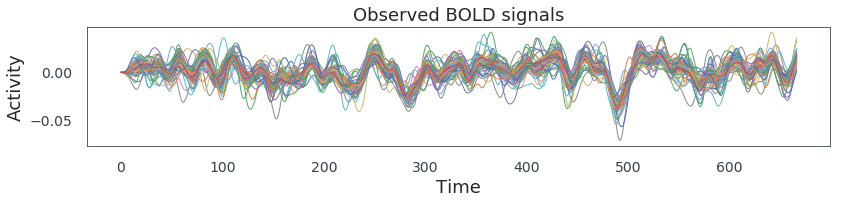

In [187]:
plt.figure(figsize=(12,3))
plt.plot(x_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Activity',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.eps"), doi=800)
plt.show()

In [188]:
FCcorr_obs=np.corrcoef(x_obs)
FCcorr_obs.shape

(84, 84)

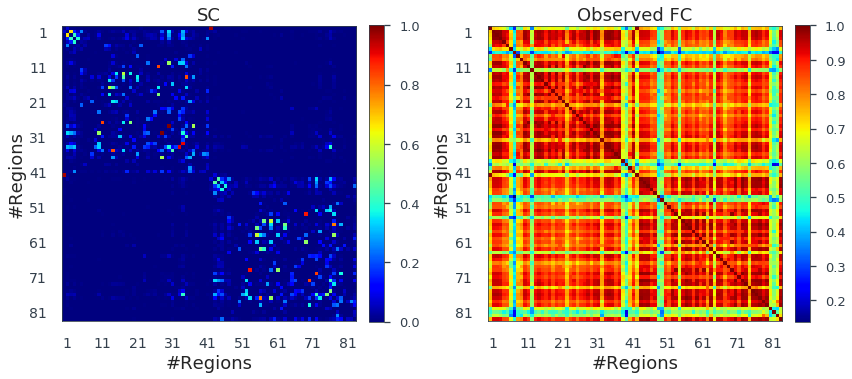

In [189]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SC', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr_obs,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_obs3.eps"), doi=800)
plt.show()

In [190]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(x_obs,wwidth,maxNwindows,olap,mode='corr')

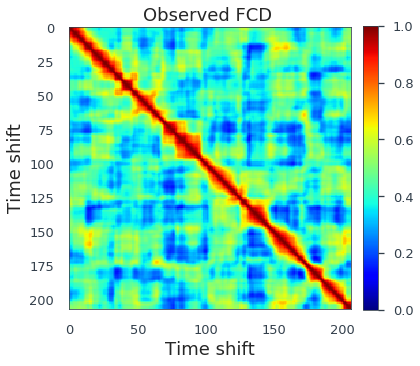

In [191]:
plt.figure(figsize=(6, 6))
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FCD_obs3.eps"), doi=800)
plt.show()

### Posterior data set 3

In [192]:
labels_params = [r'$G$']

In [193]:
num_samples=1000

In [194]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features, sample_with_mcmc=True,).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))


Generating samples: 100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]

 Sampling posterior (sec) took: 137.11718344688416


In [195]:
np.save(os.path.join(Res_dir, 'posterior_samples_GenericHopf_Hierarchy3.npy') , posterior_samples)

In [196]:
posterior_samples.shape, params_true.shape

((1000, 1), (1,))

In [197]:
G_posterior=posterior_samples[:,0]

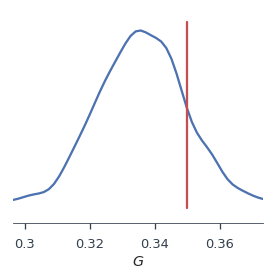

In [198]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(4,4),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=params_true,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs3.eps"), doi=800) 
plt.show()

In [199]:
G_posterior.mean()

0.33592278

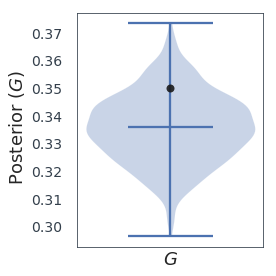

In [200]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.eps"), doi=800)
plt.show()

In [201]:
#x_fit =GenericHopfBOLD(np.percentile(posterior_sample, [50], axis=0).reshape(-1), omega, init_conditions, sigma, SC, dt, ts, dt_bold, ds, seed=0)
BOLD_fit =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC, dt, ts, dt_bold, ds)

In [202]:
x_fit=BOLD_fit.reshape(nn, int(BOLD_fit.shape[0]/nn))

In [203]:
x_obs.shape, x_fit.shape, 

((84, 667), (84, 667))

In [204]:
np.save(os.path.join(Res_dir, 'x_obs_GenericHopf_Hierarchy3.npy') , x_obs)
np.save(os.path.join(Res_dir, 'x_fit_GenericHopf_Hierarchy3.npy') , x_fit)

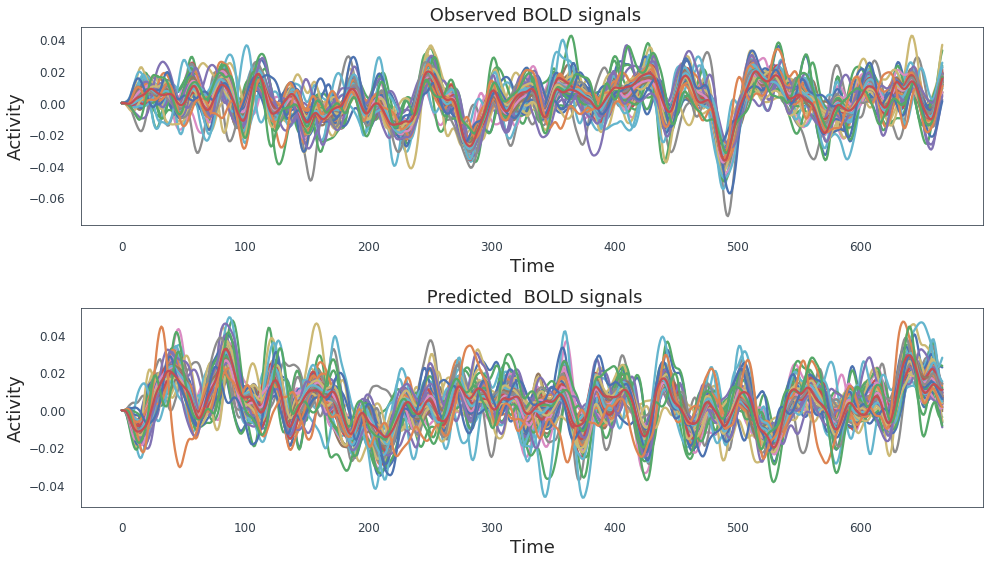

In [205]:
plt.figure(figsize=(14, 8))
plt.subplot(211);
plt.plot(x_obs.T)
plt.title(" Observed BOLD signals", fontsize=18) 
plt.xlabel("Time", fontsize=18);
plt.ylabel("Activity", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(212)
plt.plot(x_fit.T)
plt.title(" Predicted  BOLD signals", fontsize=18) 
plt.xlabel("Time", fontsize=18);
plt.ylabel("Activity", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedSeriesobservation_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedSeriesobservation_obs2.eps"), doi=800)
plt.show()

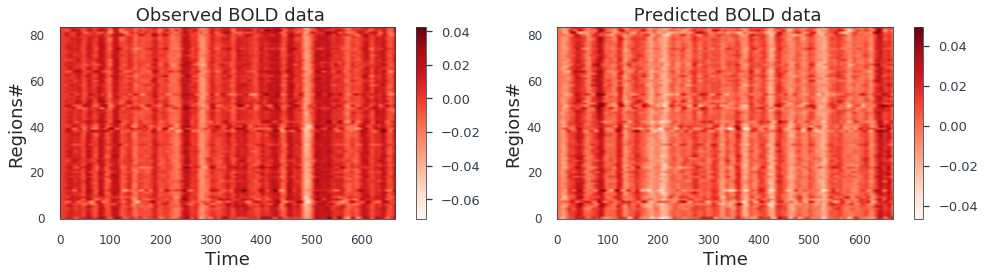

In [206]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(x_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Observed BOLD data", fontsize=18) 
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(122)
plt.imshow(x_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted BOLD data", fontsize=18) 
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_ImshowFittedobservation3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_ImshowFittedobservation3.eps"), doi=800)
plt.show()

In [207]:
FCcorr_obs=np.corrcoef(x_obs)
FCcorr_fit=np.corrcoef(x_fit)

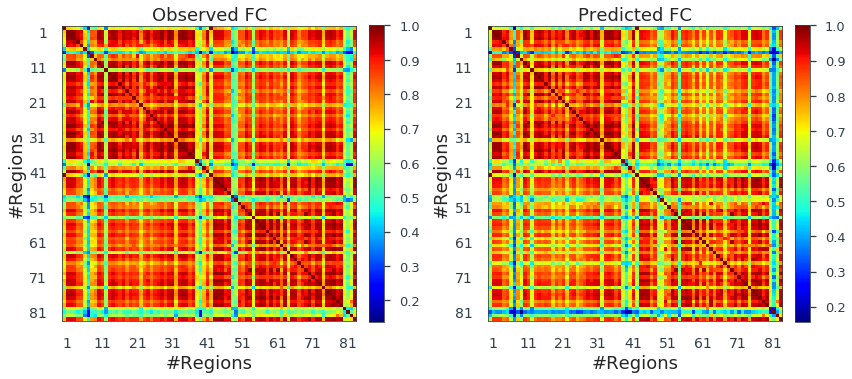

In [208]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)

plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC3.eps"), doi=800)
plt.show()

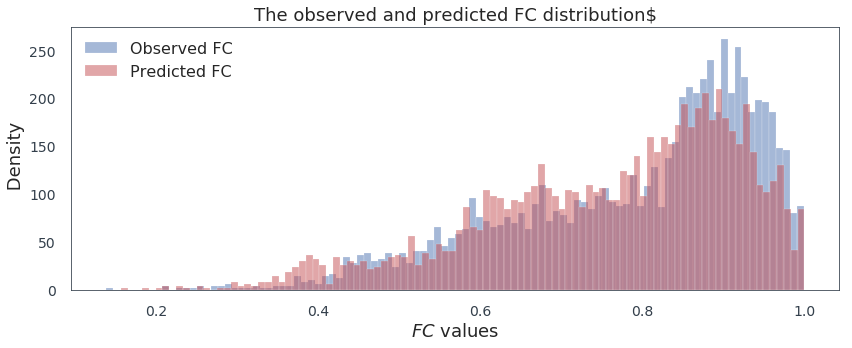

In [209]:
plt.figure(figsize=(12, 5))
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC distribution$', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFC3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFC3.eps"), doi=800)
plt.show()

In [210]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(66.33208577078386, 64.06507700243618)

In [211]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(x_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(x_fit,wwidth,maxNwindows,olap,mode='corr')

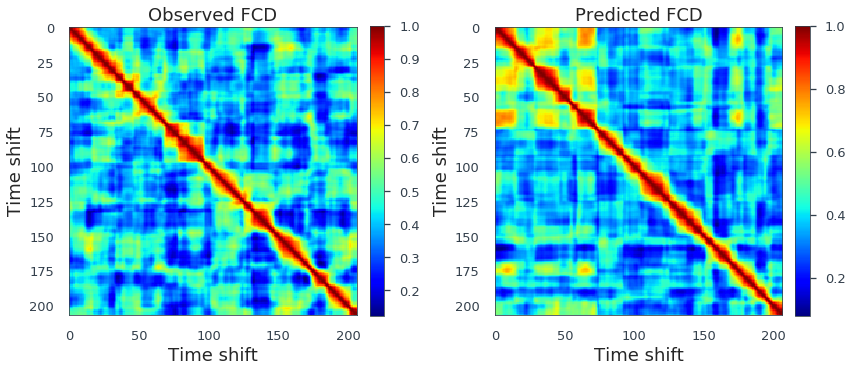

In [212]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD3.eps"), doi=800)
plt.show()

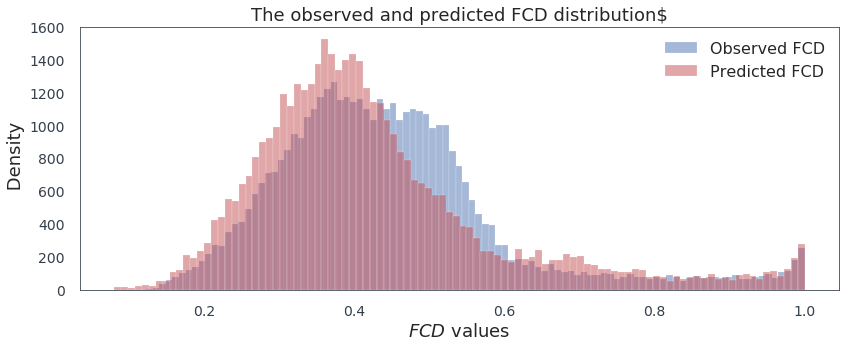

In [213]:
plt.figure(figsize=(12, 5))
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD distribution$', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFCD3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_histogramFCD3.eps"), doi=800)
plt.show()

In [214]:
#from Similaritymetrics import kl_divergence, compute_kl_divergence, js_divergence, compute_js_divergence

In [215]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from sklearn.metrics import mutual_info_score

In [216]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [217]:
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [218]:
kl_divergence(FCDcorr_obs, FCDcorr_fit)

2003.5988872842654

In [219]:
kl_divergence(FCDcorr_fit, FCDcorr_obs)

282.05128536228113

In [220]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

280.35400760292384

In [221]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.025038500090025104

In [222]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.0597331642473455

In [223]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

Ks_2sampResult(statistic=0.11085439566851041, pvalue=1.7464895318788977e-229)